# Spacecraft with reaction wheels and star tracker

Import modules and configure the notebook.

In [1]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import matplotlib.pyplot as plt

# This is my own script (it is an interface to the pybullet simulator)
import ae353_spacecraft

# I often go back and forth between making changes to my scripts and to
# the notebook in which they are used. One "gotcha" is that notebooks only
# import modules or scripts ONCE. Subsequent imports don't do anything, and
# in particular won't reflect any changes I've made to my scripts. To make
# sure that I'm working with the latest version of my code, I use this bit
# of magic, which forces the notebook to "reload" my script:
import importlib
importlib.reload(ae353_spacecraft)

<module 'ae353_spacecraft' from '/Users/timothybretl/Documents/courses/AE353/09 - AE353 (Spring 2021)/Sandbox/03_spacecraft_class/ae353_spacecraft.py'>

Define and create an instance of the robot controller. By default, it applies zero torque to all wheels. Modify the `run` function - or anything else in the class definition - to make the controller behave differently.

In [2]:
class RobotController:
    def __init__(self):
        self.dt = 0.04
        self.reset()
    
    def reset(self):
        self.xhat = np.zeros((6, 1))
    
    def run(self, p, v):
        tau = np.zeros(4)
        return tau

controller = RobotController()

## Do simulation with the GUI

Create an instance of the robot simulator.

In [ ]:
stars = np.array([[0., 0.],
                  [0.5, 0.25],
                  [0.75, 0.5],
                  [-0.1, -0.3]])

robot = ae353_spacecraft.RobotSimulator(display=True, stars=stars, scope_noise=0.)

Display a snapshot.

In [ ]:
# Get snapshot as 480 x 480 x 4 numpy array of RGBA values
rgba = robot.snapshot()

# Display snapshot
plt.figure(figsize=(9, 9))
plt.imshow(rgba)

In [ ]:
p, v = robot.get_sensor_measurements()
print(p)
print(v)

In [ ]:
np.nan

In [ ]:
np.isnan(p)

Save the snapshot.

In [ ]:
plt.imsave('my_snapshot.png', rgba)

Run the simulation.

In [ ]:
# Restore the simulation to its initial state
robot.reset()

# Restore the controller to its initial state
controller.reset()

# Choose how long we want to run the simulation, and
# compute the corresponding number of time steps
run_time = 20.0
num_steps = int(run_time/robot.dt)

# Create a dictionary in which to store results
data = {
    't': np.empty(num_steps, dtype=float),
    'v': np.empty((4, num_steps), dtype=float),
    'p': np.empty((2 * len(robot.stars), num_steps), dtype=float),
    'tau': np.empty((4, num_steps), dtype=float),
    'rpy': np.empty((3, num_steps), dtype=float),
    'angvel': np.empty((3, num_steps), dtype=float),
    'xhat': np.empty((6, num_steps), dtype=float),
}

# Run the simulation loop
start_time = time.time()
for step in range(num_steps):
    # Get the current time
    t = robot.dt * step
    
    # Get the sensor measurements
    p, v = robot.get_sensor_measurements()
    
    # Choose the actuator command (by running the controller)
    tau = controller.run(p, v)
    if tau.shape != (4, ):
        raise Exception(f'invalid desired torques: {tau}')
    
    # Get orientation and angular velocity as ground truth
    rpy, angvel = robot.get_rpy_and_angvel()
        
    # Log the data from this time step
    data['t'][step] = t
    data['v'][:, step] = v
    data['p'][:, step] = p
    data['tau'][:, step] = tau
    data['rpy'][:, step] = rpy
    data['angvel'][:, step] = angvel
    data['xhat'][:, step] = controller.xhat.flatten()
    
    # Send the actuator commands to robot and go forward one time step
    robot.set_actuator_commands(tau)
    robot.step(t=(start_time + (robot.dt * (step + 1))))
    
print(f'elapsed time: {time.time() - start_time:.1f} (should be {run_time})')

Plot the results.

In [ ]:
# Create a figure with subplots that all share the same x-axis
fig, (ax_rpy, ax_tau, ax_v) = plt.subplots(3, 1, figsize=(9, 12), sharex=True)

# Roll, pitch, and yaw angles
ax_rpy.plot(data['t'], data['rpy'][0, :], label='roll (rad)', linewidth=4)
ax_rpy.plot(data['t'], data['rpy'][1, :], label='pitch (rad)', linewidth=4)
ax_rpy.plot(data['t'], data['rpy'][2, :], label='yaw (rad)', linewidth=4)
ax_rpy.grid()
ax_rpy.legend(fontsize=16)
ax_rpy.tick_params(labelsize=14)

# Wheel torques
for i in range(4):
    ax_tau.plot(data['t'], data['tau'][i, :], label=f'torque {i} command (N-m)', linewidth=4)
ax_tau.plot(data['t'], np.ones_like(data['t']) * robot.tau_max, '--', label='max joint torque', linewidth=4, color='C2')
ax_tau.plot(data['t'], -np.ones_like(data['t']) * robot.tau_max, '--', linewidth=4, color='C2')
ax_tau.grid()
ax_tau.legend(fontsize=16)
ax_tau.tick_params(labelsize=14)
ax_tau.set_ylim(-1.2 * robot.tau_max, 1.2 * robot.tau_max)

# Wheel speeds
for i in range(4):
    ax_v.plot(data['t'], data['v'][i, :], label=f'wheel {i} speed (rad/s)', linewidth=4)
ax_v.plot(data['t'], np.ones_like(data['t']) * robot.v_max, '--', label='max wheel speed', linewidth=4, color='C2')
ax_v.plot(data['t'], -np.ones_like(data['t']) * robot.v_max, '--', linewidth=4, color='C2')
ax_v.grid()
ax_v.legend(fontsize=16)
ax_v.tick_params(labelsize=14)
ax_v.set_ylim(-1.2 * robot.v_max, 1.2 * robot.v_max)

# Set shared x-axis properties
ax_v.set_xlabel('time (s)', fontsize=20)
ax_v.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

Plot star positions in image.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
for i in range(len(robot.stars)):
    y = data['p'][2 * i, :]
    z = data['p'][2 * i + 1, :]
    ax.plot(-y, z, label=f'star {i}', linewidth=0.5, marker='.', markersize=10)
ax.grid()
ax.legend(fontsize=16)
ax.tick_params(labelsize=14)
ax.set_xlim(-1., 1.)
ax.set_ylim(-1., 1.)

## Do simulation without the GUI and create a video

Import what we need to create a video. You must install both [imageio](https://github.com/imageio/imageio) and [imageio-ffmpeg](https://github.com/imageio/imageio-ffmpeg) in order for this to work. You can do this from a terminal (in your `ae353-bullet` environment, for example) as follows:

```
pip install imageio
pip install imageio-ffmpeg
```

In [3]:
import imageio

Create an instance of the robot simulator.

In [4]:
robot = ae353_spacecraft.RobotSimulator(display=False)

Display a snapshot.

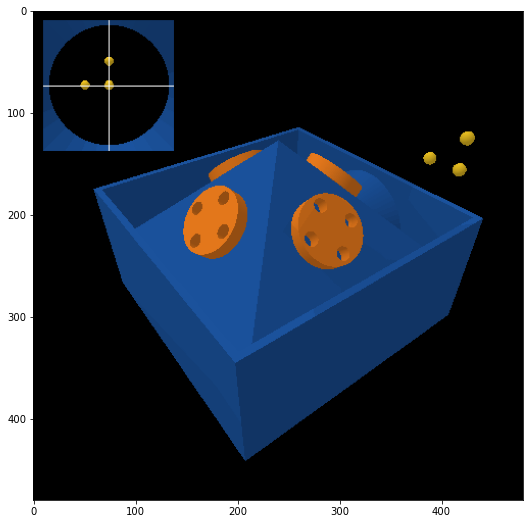

In [5]:
# Get snapshot as 480 x 480 x 4 numpy array of RGBA values
rgba = robot.snapshot()

# Display snapshot
plt.figure(figsize=(9, 9))
plt.imshow(rgba)

Save the snapshot.

In [6]:
plt.imsave('my_snapshot.png', rgba)

Run the simulation.

In [7]:
# Restore the simulation to its initial state
robot.reset()

# Restore the controller to its initial state
controller.reset()

# Choose how long we want to run the simulation, and
# compute the corresponding number of time steps
run_time = 1.0
num_steps = int(run_time/robot.dt)

# Create a dictionary in which to store results
data = {
    't': np.empty(num_steps, dtype=float),
    'v': np.empty((4, num_steps), dtype=float),
    'p': np.empty((2 * len(robot.stars), num_steps), dtype=float),
    'tau': np.empty((4, num_steps), dtype=float),
    'rpy': np.empty((3, num_steps), dtype=float),
    'angvel': np.empty((3, num_steps), dtype=float),
    'xhat': np.empty((6, num_steps), dtype=float),
}

# Open video
filename = 'my_video.mp4'
fps = int(1 / robot.dt)
print(f'Creating a video with name {filename} and fps {fps}')
w = imageio.get_writer(filename,
                       format='FFMPEG',
                       mode='I',
                       fps=fps)

# Add first frame to video
rgba = robot.snapshot()
w.append_data(rgba)

# Run the simulation loop
print(f' step {0:04d} / {num_steps:04d}')
start_time = time.time()
for step in range(num_steps):
    if ((step + 1) % fps) == 0:
        print(f' step {step + 1:04d} / {num_steps:04d}')
    
    # Get the current time
    t = robot.dt * step
    
    # Get the sensor measurements
    p, v = robot.get_sensor_measurements()
    
    # Choose the actuator command (by running the controller)
    tau = controller.run(p, v)
    if tau.shape != (4, ):
        raise Exception(f'invalid desired torques: {tau}')
    
    # Get orientation and angular velocity as ground truth
    rpy, angvel = robot.get_rpy_and_angvel()
        
    # Log the data from this time step
    data['t'][step] = t
    data['v'][:, step] = v
    data['p'][:, step] = p
    data['tau'][:, step] = tau
    data['rpy'][:, step] = rpy
    data['angvel'][:, step] = angvel
    data['xhat'][:, step] = controller.xhat.flatten()
    
    # Send the actuator commands to robot and go forward one time step
    robot.set_actuator_commands(tau)
    robot.step(t=(start_time + (robot.dt * (step + 1))))
    
    # Add frame to video
    rgba = robot.snapshot()
    w.append_data(rgba)

# Close video
w.close()
print(f'elapsed time: {time.time() - start_time:.1f} (should be {run_time})')

Creating a video with name my_video.mp4 and fps 25
 step 0000 / 0025
 step 0025 / 0025
elapsed time: 9.8 (should be 1.0)


Plot the results.

In [ ]:
# Create a figure with subplots that all share the same x-axis
fig, (ax_rpy, ax_tau, ax_v) = plt.subplots(3, 1, figsize=(9, 12), sharex=True)

# Roll, pitch, and yaw angles
ax_rpy.plot(data['t'], data['rpy'][0, :], label='roll (rad)', linewidth=4)
ax_rpy.plot(data['t'], data['rpy'][1, :], label='pitch (rad)', linewidth=4)
ax_rpy.plot(data['t'], data['rpy'][2, :], label='yaw (rad)', linewidth=4)
ax_rpy.grid()
ax_rpy.legend(fontsize=16)
ax_rpy.tick_params(labelsize=14)

# Wheel torques
for i in range(4):
    ax_tau.plot(data['t'], data['tau'][i, :], label=f'torque {i} command (N-m)', linewidth=4)
ax_tau.plot(data['t'], np.ones_like(data['t']) * robot.tau_max, '--', label='max joint torque', linewidth=4, color='C2')
ax_tau.plot(data['t'], -np.ones_like(data['t']) * robot.tau_max, '--', linewidth=4, color='C2')
ax_tau.grid()
ax_tau.legend(fontsize=16)
ax_tau.tick_params(labelsize=14)
ax_tau.set_ylim(-1.2 * robot.tau_max, 1.2 * robot.tau_max)

# Wheel speeds
for i in range(4):
    ax_v.plot(data['t'], data['v'][i, :], label=f'wheel {i} speed (rad/s)', linewidth=4)
ax_v.plot(data['t'], np.ones_like(data['t']) * robot.v_max, '--', label='max wheel speed', linewidth=4, color='C2')
ax_v.plot(data['t'], -np.ones_like(data['t']) * robot.v_max, '--', linewidth=4, color='C2')
ax_v.grid()
ax_v.legend(fontsize=16)
ax_v.tick_params(labelsize=14)
ax_v.set_ylim(-1.2 * robot.v_max, 1.2 * robot.v_max)

# Set shared x-axis properties
ax_v.set_xlabel('time (s)', fontsize=20)
ax_v.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

Plot star positions in image.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
for i in range(len(robot.stars)):
    y = data['p'][2 * i, :]
    z = data['p'][2 * i + 1, :]
    ax.plot(-y, z, label=f'star {i}', linewidth=0.5, marker='.', markersize=10)
ax.grid()
ax.legend(fontsize=16)
ax.tick_params(labelsize=14)
ax.set_xlim(-1., 1.)
ax.set_ylim(-1., 1.)